In [1]:
import sys
sys.path.append('../')

In [2]:
from scripts.utils import data_path
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
%matplotlib inline

# Counterparts and field sources catalogs construction

## Load DESI-CSC 50 arcsec cone search match

### preprocessing: load DESI-CSC 50 arcsec cone search match and join it with CSC data frame to get fluxes/errors.

In [3]:
desi_csc_orig = pd.read_pickle(data_path+'/csc_desi_r50_gaia.gz_pkl',compression='gzip')
desi_csc_orig['name_csc'] = desi_csc_orig['name_csc'].astype(str).str[2:-2] #fix bug in name_csc string

In [4]:
#load CSC  raw data so that I get positional errors and X-ray fluxes.
#it will be fixed in the future by MB #TODO
#see https://github.com/mbelveder/csc_xmm/blob/master/def_csc_xmm.py

csc_orig = pd.read_pickle(data_path+'/csc_init_df.gz_pkl',compression='gzip')
csc_orig.rename(columns={'name':'name_csc'},inplace=True) #TODO

In [5]:
#add chanda localisation error and flux
desi_csc_orig = desi_csc_orig.merge(csc_orig[['name_csc', 'flux_csc_05_2', 'r_98_csc' ]], on='name_csc')


#add magnitudes (NOT DEREDDENED) #TODO 
#later make cut on the SNS of flux #TODO
def flux2mag(flux):
    return 22.5 - 2.5 * np.log10(flux)


for flux_name in ['flux_g', 'flux_r', 'flux_z',
                    'flux_w1', 'flux_w2', 'flux_w3', 'flux_w4']:

    desi_csc_orig['mag_' + flux_name.split('_')[1]] = flux2mag(desi_csc_orig[flux_name])


/Users/sdbykov/opt/miniconda3/envs/venv_hea/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sdbykov/opt/miniconda3/envs/venv_hea/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sdbykov/opt/miniconda3/envs/venv_hea/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sdbykov/opt/miniconda3/envs/venv_hea/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sdbykov/opt/miniconda3/envs/venv_hea/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = geta

### Primary filters and DESI duplicates (ra,dec) removal

In [6]:
#step 1: filter brick ID
#next sort by name_csc, ra, dec and flux_g, with flux_g from largest to smallest
desi_csc = desi_csc_orig.query('brick_primary == True')
desi_csc = desi_csc.sort_values(by=['name_csc', 'ra_csc', 'dec_csc', 'flux_g'], ascending=[True, True, True, False])

#step 2: remove duplicates in ['ra_csc', 'dec_csc', 'ra', 'dec'] and keep the one with the highest flux_g 
desi_csc = desi_csc.drop_duplicates(subset=['ra_csc', 'dec_csc', 'ra', 'dec'], keep='first')


#assign desi_id
tm_desi_id=desi_csc['release'].astype(str)+'_'+desi_csc['brickid'].astype(str)+'_'+desi_csc['objid'].astype(str)
desi_csc['desi_id'] = tm_desi_id

#sort by sep_csc so that the closest objects are first
desi_csc.sort_values(by=['name_csc', 'sep_csc'], inplace=True)
desi_csc

,name_csc,ra_csc,dec_csc,sep_csc,release,brickid,objid,brick_primary,type,ra,dec,ra_ivar,dec_ivar,flux_g,flux_r,flux_z,flux_w1,flux_w2,flux_w3,flux_w4,pmra,pmdec,parallax,pmra_ivar,pmdec_ivar,parallax_ivar,flux_csc_05_2,r_98_csc,mag_g,mag_r,mag_z,mag_w1,mag_w2,mag_w3,mag_w4,desi_id
421517,2CXO J000000.0+004331,0.000020,0.725285,2.965885,9010,336127,9384,True,b'PSF',359.999368,0.725789,9.995912e+13,8.235358e+14,33.598339,120.691429,347.113159,220.591248,123.600243,-19.046621,8024.836426,-17.185482,-22.635811,1.800885,2.088990,15.761224,6.627885,2.625836e-15,1.376434,18.684205,17.295809,16.148822,16.641029,17.269952,NaN,12.738910,9010_336127_9384
421515,2CXO J000000.0+004331,0.000020,0.725285,3.009207,9010,336127,9377,True,b'PSF',359.999224,0.725541,8.586270e+13,1.734593e+15,40.019753,136.900681,292.141724,157.427063,88.422371,-1.826197,-10256.850586,-24.401419,-22.808395,1.394833,1.649246,36.086342,26.638435,2.625836e-15,1.376434,18.494314,17.158986,16.336016,17.007301,17.633595,NaN,NaN,9010_336127_9377
421520,2CXO J000000.0+004331,0.000020,0.725285,6.234415,9010,336127,9400,True,b'REX',359.999865,0.723560,2.646932e+09,2.572524e+09,0.097673,0.187437,0.315897,4.655342,0.342395,-40.755623,1300.431641,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.625836e-15,1.376434,25.025561,24.317862,23.751137,20.830121,23.663681,NaN,14.714781,9010_336127_9400
421509,2CXO J000000.0+004331,0.000020,0.725285,8.171573,9010,336127,9329,True,b'PSF',359.998067,0.724128,2.557782e+09,2.452376e+09,0.061725,0.109753,0.177924,0.317055,-2.643466,-29.123890,540.083557,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.625836e-15,1.376434,25.523843,24.898956,24.374414,23.747163,NaN,NaN,15.668848,9010_336127_9329
421507,2CXO J000000.0+004331,0.000020,0.725285,8.220221,9010,336127,9313,True,b'PSF',359.997752,0.725017,1.499534e+09,1.479013e+09,0.044484,0.083486,0.166107,6.243100,-0.107159,-50.138081,2567.639893,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.625836e-15,1.376434,25.879498,25.195961,24.449033,20.511499,NaN,NaN,13.976164,9010_336127_9313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8519446,2CXO J235959.9-093415,359.999961,-9.570990,46.663889,9010,275866,45,True,b'PSF',0.002650,-9.558302,1.211937e+11,1.265080e+11,0.556918,1.996776,7.372591,4.829638,2.783169,-33.320595,66.236778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,1.895908,23.135523,21.749177,20.330950,20.790214,21.388651,NaN,17.947252,9010_275866_45
8519464,2CXO J235959.9-093415,359.999961,-9.570990,46.985982,9010,275866,232,True,b'REX',0.013162,-9.571927,1.446738e+09,1.496325e+09,0.144224,0.426922,0.125689,-1.962596,-3.686983,61.044807,-336.471375,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,1.895908,24.602404,23.424130,24.751757,NaN,NaN,18.035878,NaN,9010_275866_232
8519433,2CXO J235959.9-093415,359.999961,-9.570990,47.171155,9010,277287,4877,True,b'REX',359.998868,-9.557932,5.422604e+08,5.475597e+08,0.229933,0.451860,1.205120,7.201839,2.480816,-23.814928,196.763016,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,1.895908,24.095998,23.362491,22.297424,20.356392,21.513514,NaN,16.765141,9010_277287_4877
8519462,2CXO J235959.9-093415,359.999961,-9.570990,47.891160,9010,275866,209,True,b'PSF',0.011928,-9.564850,2.994884e+09,3.149741e+09,0.142126,0.383094,0.657095,0.585577,-0.129775,64.727432,-219.528992,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,1.895908,24.618318,23.541736,22.955930,23.081039,NaN,17.972279,NaN,9010_275866_209


## Calculating source densities and false association radius (r_false) for each CSC source 

In [7]:
def annuli_area_deg2(r_in_arcsec, r_out_arcsec):
    r_in_deg = r_in_arcsec/3600
    r_out_deg = r_out_arcsec/3600
    area = np.pi*(r_out_deg**2 - r_in_deg**2)
    return area

def r_false(desi_rho_deg2, thresh = 0.03):
    ''' Belvedersky+ 2022 '''
    desi_rho_arcsec2 = desi_rho_deg2/(3600**2)
    return np.sqrt(-np.log(1-thresh)/(np.pi*desi_rho_arcsec2))


#make a dataframe of CSC sources
csc = pd.DataFrame(desi_csc.groupby(by = 'name_csc', ).agg({'ra_csc': np.mean, 'dec_csc': np.mean}))

#calculate total number of DESI sources withing 50'' of each CSC source
csc['desi_tot'] = desi_csc.groupby(by = 'name_csc', ).agg({'sep_csc': ['count']})

#calculate total number of DESI sources withing 0-10-50 arcsec of each CSC source
csc[['desi_sep_10_50']] =  desi_csc.groupby(by = ['name_csc', pd.cut(desi_csc.sep_csc, [10, 50]) ]).size().unstack()



#calculate source densities for 0-50'' annulus and 10-50'' annulus
csc['src_dens_deg2'] = csc['desi_tot']/annuli_area_deg2(0, 50)
csc['src_dens_deg2_sep_10_50'] = csc['desi_sep_10_50']/annuli_area_deg2(10, 50)

#drop sources with  zeros in the 10-50'' source density 
print('dropping X-ray sources with zero in the 10-50'' source density,', len(csc[csc.src_dens_deg2_sep_10_50 == 0]), ' sources')
csc.drop(csc[csc.src_dens_deg2_sep_10_50 == 0].index, inplace=True)


#assign r_false for 10-50'' annulus density
csc['r_false_003_dens_deg2_sep_10_50'] = r_false(csc['src_dens_deg2_sep_10_50'])

csc.reset_index(inplace=True)

#assign r_false for each CSC source from csc dataframe to desi_csc dataframe
desi_csc = desi_csc.merge(csc[['name_csc','r_false_003_dens_deg2_sep_10_50']], on='name_csc')


dropping X-ray sources with zero in the 10-50 source density, 4  sources


In [8]:
#column whether sep_csc < r_98_csc
desi_csc['sep_csc_less_r_98'] = desi_csc.sep_csc < desi_csc.r_98_csc

#column whether sep_csc < r_false
desi_csc['sep_csc_less_r_false'] = desi_csc.sep_csc < desi_csc.r_false_003_dens_deg2_sep_10_50



#calculate for each CSC source the number of DESI sources within r_false
tmp_df = pd.DataFrame(desi_csc.query('sep_csc <= r_false_003_dens_deg2_sep_10_50').groupby(by = 'name_csc').sep_csc.apply('count'))
print(tmp_df.sep_csc.value_counts())
tmp_df.columns = ['total_sep_csc_less_r_98']


#merge with desi_csc dataframe
desi_csc = desi_csc.merge(tmp_df, on='name_csc')
desi_csc.head(10)

1    77254
2     5714
3       81
4       10
5        1
Name: sep_csc, dtype: int64


,name_csc,ra_csc,dec_csc,sep_csc,release,brickid,objid,brick_primary,type,ra,dec,ra_ivar,dec_ivar,flux_g,flux_r,flux_z,flux_w1,flux_w2,flux_w3,flux_w4,pmra,pmdec,parallax,pmra_ivar,pmdec_ivar,parallax_ivar,flux_csc_05_2,r_98_csc,mag_g,mag_r,mag_z,mag_w1,mag_w2,mag_w3,mag_w4,desi_id,r_false_003_dens_deg2_sep_10_50,sep_csc_less_r_98,sep_csc_less_r_false,total_sep_csc_less_r_98
0,2CXO J000001.4+004822,0.006048,0.806176,0.605695,9011,334688,42,True,b'PSF',0.006146,0.806313,2.114977e+09,2.371039e+09,0.000000,0.000000,1.362053,5.890132,5.541679,82.851456,-1865.469727,0.0,0.0,0.0,0.0,0.0,0.0,3.011100e-15,5.565419,inf,inf,22.164515,20.574687,20.640897,17.704250,NaN,9011_334688_42,0.815208,True,True,2
1,2CXO J000001.4+004822,0.006048,0.806176,0.607102,9010,334688,236,True,b'DEV',0.006153,0.806308,2.004298e+10,2.495484e+10,0.308400,0.731828,1.758477,5.784090,5.948933,72.709251,-3279.481445,0.0,0.0,0.0,0.0,0.0,0.0,3.011100e-15,5.565419,23.777216,22.838977,21.887158,20.594413,20.563902,17.846026,NaN,9010_334688_236,0.815208,True,True,2
2,2CXO J000001.4+004822,0.006048,0.806176,3.455084,9011,334688,37,True,b'REX',0.005853,0.805236,1.939082e+09,2.034859e+09,0.000000,0.000000,1.732727,9.165393,5.250703,-30.357681,1504.111206,0.0,0.0,0.0,0.0,0.0,0.0,3.011100e-15,5.565419,inf,inf,21.903175,20.094622,20.699456,NaN,14.556800,9011_334688_37,0.815208,True,False,2
3,2CXO J000001.4+004822,0.006048,0.806176,3.528270,9010,334688,219,True,b'REX',0.005867,0.805213,3.240347e+10,3.133785e+10,0.426233,0.787408,1.819734,7.825049,3.032816,53.774387,4549.550293,0.0,0.0,0.0,0.0,0.0,0.0,3.011100e-15,5.565419,23.425883,22.759500,21.849980,20.266282,21.295385,18.173561,13.355079,9010_334688_219,0.815208,True,False,2
4,2CXO J000001.4+004822,0.006048,0.806176,5.646409,9010,334688,301,True,b'PSF',0.007534,0.805674,3.146674e+09,3.039974e+09,0.081621,0.128611,0.314378,-0.178541,1.436539,41.616497,-3814.807617,0.0,0.0,0.0,0.0,0.0,0.0,3.011100e-15,5.565419,25.220492,24.726804,23.756370,NaN,22.106707,18.451836,NaN,9010_334688_301,0.815208,False,False,2
5,2CXO J000001.4+004822,0.006048,0.806176,5.736854,9010,334688,193,True,b'REX',0.005220,0.804815,2.061367e+09,1.996986e+09,0.078122,0.167909,0.489794,0.228550,2.578548,-16.056520,934.054993,0.0,0.0,0.0,0.0,0.0,0.0,3.011100e-15,5.565419,25.268069,24.437313,23.274966,24.102549,21.471562,NaN,15.074069,9010_334688_193,0.815208,False,False,2
6,2CXO J000001.4+004822,0.006048,0.806176,6.540576,9010,334688,321,True,b'REX',0.007855,0.806364,3.229775e+09,3.166041e+09,0.017123,0.063340,0.587138,3.980444,0.187302,-126.665192,4614.424316,0.0,0.0,0.0,0.0,0.0,0.0,3.011100e-15,5.565419,26.916045,25.495804,23.078150,21.000171,24.318642,NaN,13.339706,9010_334688_321,0.815208,False,False,2
7,2CXO J000001.4+004822,0.006048,0.806176,7.186883,9010,334688,299,True,b'REX',0.007398,0.807647,2.718235e+10,2.656447e+10,0.553825,1.111922,1.619816,1.388356,2.160482,42.309448,-799.444885,0.0,0.0,0.0,0.0,0.0,0.0,3.011100e-15,5.565419,23.141569,22.384814,21.976336,22.143748,21.663623,18.433907,NaN,9010_334688_299,0.815208,False,False,2
8,2CXO J000001.4+004822,0.006048,0.806176,7.204947,9011,334688,58,True,b'REX',0.007386,0.807665,1.655252e+09,1.723114e+09,0.000000,0.000000,1.473536,4.127965,3.964491,-21.072779,741.889832,0.0,0.0,0.0,0.0,0.0,0.0,3.011100e-15,5.565419,inf,inf,22.079098,20.960660,21.004531,NaN,15.324152,9011_334688_58,0.815208,False,False,2
9,2CXO J000001.4+004822,0.006048,0.806176,8.618342,9010,334688,221,True,b'REX',0.005876,0.803788,8.693356e+09,7.951351e+09,0.277541,0.267392,0.397522,0.619469,-1.727588,-148.618973,-2438.192871,0.0,0.0,0.0,0.0,0.0,0.0,3.011100e-15,5.565419,23.891683,23.932128,23.501598,23.019951,NaN,NaN,NaN,9010_334688_221,0.815208,False,False,2


## Counterpart quality assignment

In [9]:
## assign counterparts quality flags
# if sep_csc_less_r_98 AND sep_csc_less_r_false AND total_sep_csc_less_r_98==1 => very secure coutnerspart
# if sep_csc_less_r_98 AND not sep_csc_less_r_false AND total_sep_csc_less_r_98==1 => secure coutnerspart

def counterpart_quality_flag(row):
    if row.sep_csc_less_r_98 and row.sep_csc_less_r_false and row.total_sep_csc_less_r_98==1:
        return 1
    elif not row.sep_csc_less_r_98 and  row.sep_csc_less_r_false and row.total_sep_csc_less_r_98==1:
        return 2
    else:
        return 0

desi_csc['counterpart_quality_flag'] = desi_csc.apply(counterpart_quality_flag, axis=1)

In [10]:
print('counterparts by flag:')
desi_csc['counterpart_quality_flag'].value_counts()

counterparts by flag:


0    5179490
1      77133
2        121
Name: counterpart_quality_flag, dtype: int64

In [13]:
desi_csc_ctps = desi_csc[desi_csc.counterpart_quality_flag != 0]


In [14]:
print('delete ', desi_csc_ctps.duplicated(subset='desi_id').sum(), ' duplicated desi_id')
desi_csc_ctps.drop_duplicates(subset='desi_id', inplace=True)
print('number of counterparts:', len(desi_csc_ctps))
#dublicates will appear here if untreated
#desi_csc_ctps.pivot_table(values='name_csc', index='desi_id', aggfunc='count').sort_values(by = 'name_csc',ascending=False)

delete  46  duplicated desi_id
number of counterparts: 77208


/var/folders/hk/rctb6p8n16nbrbnjrwzrc8680000gp/T/ipykernel_14393/2071945887.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desi_csc_ctps.drop_duplicates(subset='desi_id', inplace=True)


## Field source assignment

In [18]:
desi_csc_field = desi_csc.query("sep_csc>=10 & sep_csc<=50 ")
print('number of possible field sources: ', len(desi_csc_field))
fraction_to_retain = 0.1
print('fraction to retain: ', fraction_to_retain, ',approx', int(len(desi_csc_field)*fraction_to_retain), 'field sources')

number of possible field sources:  4945706
fraction to retain:  0.1 ,approx 494570 field sources


In [19]:
print('number of field sources with this much X-ray counterparts (i.e. sep<50''): ')
tmp_df = desi_csc_field.groupby(by = 'desi_id', ).agg({'name_csc': 'count'})
print(tmp_df.value_counts())
clear_field_ids = tmp_df.index[tmp_df['name_csc']==1]
desi_csc_field = desi_csc_field[desi_csc_field.desi_id.isin(clear_field_ids)==True]
desi_csc_field = desi_csc_field.sample(frac=fraction_to_retain)
print(f'number of secure field sources  ({fraction_to_retain} of it): ', len(desi_csc_field))

number of field sources with this much X-ray counterparts (i.e. sep<50): 
name_csc
1           3269476
2            584040
3            112670
4             24238
5              6683
6              2525
7              1283
8               739
9               365
10              205
11              123
12               78
14               48
13               44
16               23
15               15
17                6
18                6
19                2
21                1
dtype: int64
number of field secure (0.1 of it):  326948


## Saving the catalogs

In [20]:
desi_csc_ctps.to_pickle(data_path+'csc_desi_r50_gaia_ctps.gz_pkl', compression='gzip')
desi_csc_field.to_pickle(data_path+'csc_desi_r50_gaia_field.gz_pkl', compression='gzip')

# Funny DESI source near 21 Chandra detections

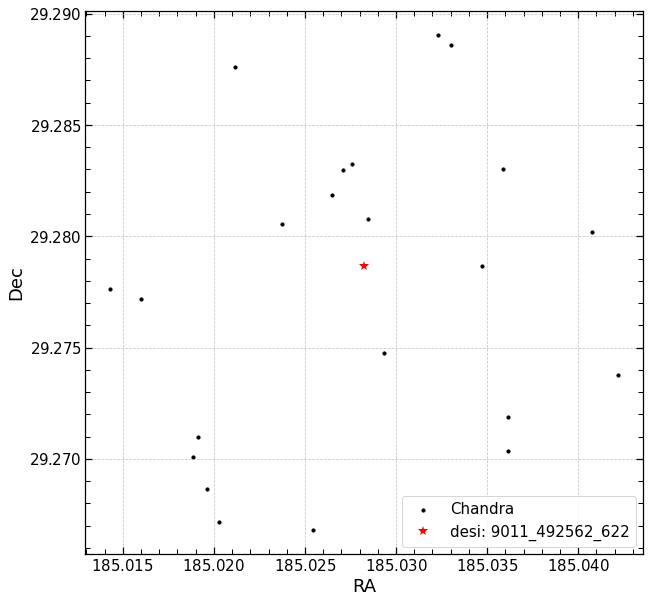

In [39]:
tmp_id = tmp_df[tmp_df.name_csc==21].index.values[0]
tmp_coords = desi_csc.query('desi_id==@tmp_id')


#plot the X-ray positions of the tmp_coords (ra_csc, dec_csc)
plt.figure(figsize=(10,10))
plt.scatter(tmp_coords.ra_csc, tmp_coords.dec_csc, c='k', s=10, label = 'Chandra')
plt.plot(tmp_coords.ra.values[0], tmp_coords.dec.values[0], '*r', ms = 10, label = 'desi: '+str(tmp_id))
plt.xlabel('RA')
plt.ylabel('Dec')
plt.legend()
